# Handwritten Digit Recognition on MNIST Data using PyTorch 
## Architecture 2: Convolutional Neural Network using SGD optimizer
### Accuracy Obtained: 98.7%

### Necessary imports


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from torchvision import datasets, transforms

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

#import helper
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# moves your model to train on your gpu if available else it uses your cpu
device = ("cuda" if torch.cuda.is_available() else "cpu")

### Download the Dataset and Define the Transforms

In [ ]:
# Define transform to normalize data
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))
                                ])



# Download and load the training data
train_set = datasets.MNIST('MNIST_DATASET/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

test_set = datasets.MNIST('MNIST_DATASET/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

### Exploring the Data

In [ ]:
training_data = enumerate(trainloader)
batch_idx, (images, labels) = next(training_data)
print(type(images)) # Checking the datatype 
print(images.shape) # the size of the image
print(labels.shape) # the size of the labels

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


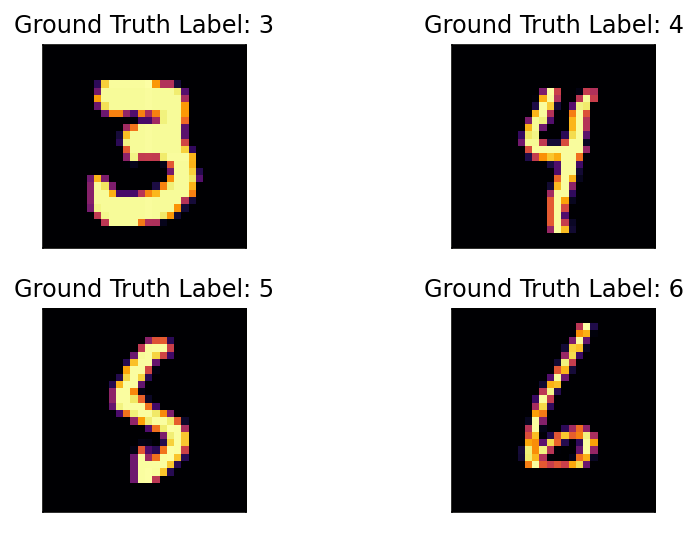

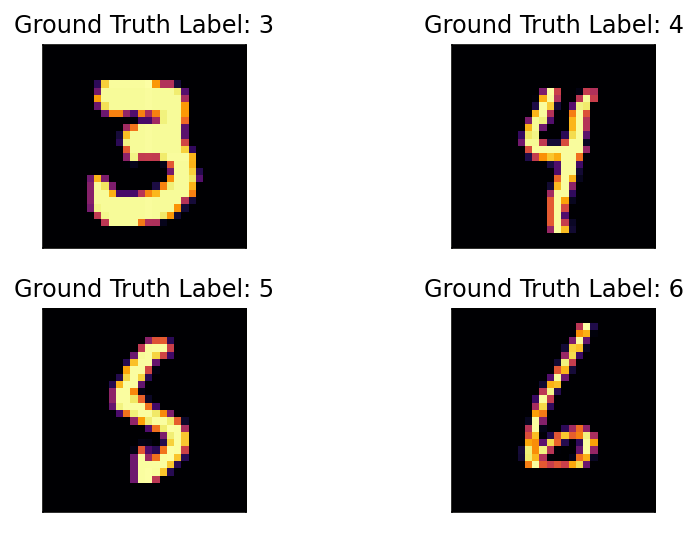

In [ ]:
fig = plt.figure()
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.tight_layout()
    plt.imshow(images[i][0], cmap='inferno')
    plt.title("Ground Truth Label: {}".format(labels[i]))
    plt.yticks([])
    plt.xticks([])
fig

### Defining the Convolutional Neural Network Architecture


In [ ]:
class Network(nn.Module):

    def __init__(self):
        super(Network, self).__init__()
        # Convolutional Neural Network Layer 
        self.convolutaional_neural_network_layers = nn.Sequential(
                # Here we are defining our 2D convolutional layers
                # We can calculate the output size of each convolutional layer using the following formular
                # outputOfEachConvLayer = [(in_channel + 2*padding - kernel_size) / stride] + 1
                # We have in_channels=1 because our input is a grayscale image
                nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3, padding=1, stride=1), # (N, 1, 28, 28) 
                nn.ReLU(),
                # After the first convolutional layer the output of this layer is:
                # [(28 + 2*1 - 3)/1] + 1 = 28. 
                nn.MaxPool2d(kernel_size=2), 
                # Since we applied maxpooling with kernel_size=2 we have to divide by 2, so we get
                # 28 / 2 = 14
          
                # output of our second conv layer
                nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, padding=1, stride=1),
                nn.ReLU(),
                # After the second convolutional layer the output of this layer is:
                # [(14 + 2*1 - 3)/1] + 1 = 14. 
                nn.MaxPool2d(kernel_size=2) 
                # Since we applied maxpooling with kernel_size=2 we have to divide by 2, so we get
                # 14 / 2 = 7
        )

        # Linear layer
        self.linear_layers = nn.Sequential(
                # We have the output_channel=24 of our second conv layer, and 7*7 is derived by the formular 
                # which is the output of each convolutional layer
                nn.Linear(in_features=24*7*7, out_features=64),          
                nn.ReLU(),
                nn.Dropout(p=0.2), # Dropout with probability of 0.2 to avoid overfitting
                nn.Linear(in_features=64, out_features=10) # The output is 10 which should match the size of our class
        )

    # Defining the forward pass 
    def forward(self, x):
        x = self.convolutaional_neural_network_layers(x)
        # After we get the output of our convolutional layer we must flatten it or rearrange the output into a vector
        x = x.view(x.size(0), -1)
        # Then pass it through the linear layer
        x = self.linear_layers(x)
        # The softmax function returns the prob likelihood of getting the input image. 
        # We will see a much graphical demonstration below
        x = F.log_softmax(x, dim=1)
        return x

In [ ]:
model = Network()
model.to(device)
print(model)

Network(
  (convolutaional_neural_network_layers): Sequential(
    (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=1176, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

### Training and Testing the Model over multiple Epochs

In [ ]:
epochs = 25 # The total number of iterations

train_losses = []
test_losses = []

for epoch in range(epochs):
    # prep model for training
    model.train()
    train_loss = 0

    for idx, (images, labels) in enumerate(trainloader): 

        # Send these >>> To GPU
        images = images.to(device)
        labels = labels.to(device)

        # Training pass
        optimizer.zero_grad()

        # Forward pass
        train_output = model(images)
        loss = criterion(train_output, labels)

        #Backward pass
        loss.backward()
        optimizer.step()

        #Total loss of one epoch
        train_loss += loss.item()
        
    else:
        # prep model for evaluation
        model.eval() 
        test_loss = 0
        test_loss1 = 0
        accuracy = 0

        # Turn off the gradients when performing validation.
        # If we don't turn it off, we will comprise our networks weight entirely
        with torch.no_grad():
            for images, labels in testloader:
                
                images = images.to(device)
                labels = labels.to(device)
                
                test_output = model(images)
                loss = criterion(test_output, labels)
                test_loss += loss.item()
                
                #other way of doing it
                #test_loss += criterion(test_output, labels)

                probabilities = torch.exp(test_output)
                top_prob, top_class = probabilities.topk(1, dim=1)
                predictions = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(predictions.type(torch.FloatTensor))

        #Losses from each epoch are stored in an array
        train_losses.append(train_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print("Epoch: {}/{}  ".format(epoch+1, epochs),
              "Training loss: {:.4f}  ".format(train_loss/len(trainloader)),
              "Testing loss: {:.4f}  ".format(test_loss/len(testloader)),
              "Test accuracy: {:.4f} %  ".format(100*(accuracy/len(testloader))))

Epoch: 1/25   Training loss: 0.6977   Testing loss: 0.2438   Test accuracy: 92.6254%  
Epoch: 2/25   Training loss: 0.2240   Testing loss: 0.1361   Test accuracy: 96.0191%  
Epoch: 3/25   Training loss: 0.1548   Testing loss: 0.1169   Test accuracy: 96.3376%  
Epoch: 4/25   Training loss: 0.1239   Testing loss: 0.0839   Test accuracy: 97.4821%  
Epoch: 5/25   Training loss: 0.1029   Testing loss: 0.0666   Test accuracy: 97.8702%  
Epoch: 6/25   Training loss: 0.0916   Testing loss: 0.0622   Test accuracy: 98.0991%  
Epoch: 7/25   Training loss: 0.0823   Testing loss: 0.0555   Test accuracy: 98.0991%  
Epoch: 8/25   Training loss: 0.0752   Testing loss: 0.0533   Test accuracy: 98.2385%  
Epoch: 9/25   Training loss: 0.0684   Testing loss: 0.0523   Test accuracy: 98.3280%  
Epoch: 10/25   Training loss: 0.0652   Testing loss: 0.0456   Test accuracy: 98.4674%  
Epoch: 11/25   Training loss: 0.0615   Testing loss: 0.0448   Test accuracy: 98.5271%  
Epoch: 12/25   Training loss: 0.0582   Te

An accuracy of  98.7% was achieved after 25 epochs on the test set.


### Visualizing the Losses

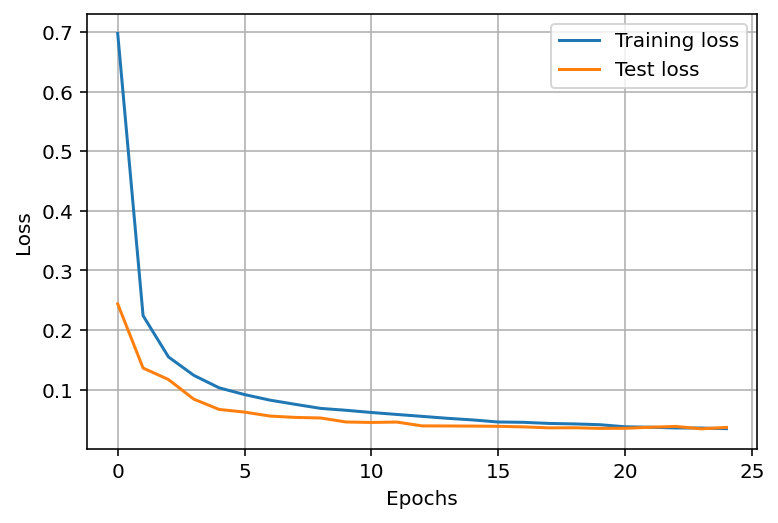

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

### Evaluating the Network

In [ ]:
img = images[0]
img = img.to(device)
img = img.view(-1, 1, 28, 28)
print(img.shape)

# Since we want to use the already pretrained weights to make some prediction
# we are turning off the gradients
with torch.no_grad():
    logits = model.forward(img)

torch.Size([1, 1, 28, 28])


[2.7517247e-10 5.1997717e-06 2.8083118e-09 8.8997865e-10 9.9998009e-01
 2.4617865e-08 2.6124136e-08 2.1241183e-06 3.0392691e-08 1.2615827e-05]


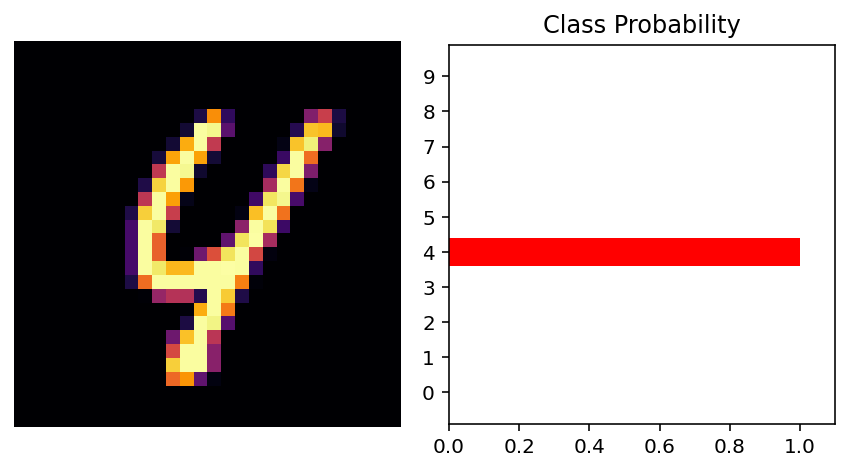

In [ ]:
# We take the softmax for probabilites since our outputs are logits
probabilities = F.softmax(logits, dim=1).detach().cpu().numpy().squeeze()

print(probabilities)

fig, (ax1, ax2) = plt.subplots(figsize=(6,8), ncols=2)
ax1.imshow(img.view(1, 28, 28).detach().cpu().numpy().squeeze(), cmap='inferno')
ax1.axis('off')
ax2.barh(np.arange(10), probabilities, color='r' )
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)

plt.tight_layout()

We can see the input image 4 matches the probability with the highest value in the probability class figure.

In [ ]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy() # Just use cpu in this case as it is not compatible with gpu
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

The model is used to classify 20 random images from the test set.
If the digit is predicted correct then it displays the number in green. If the prediction is incorrect, then it displays the number in red.

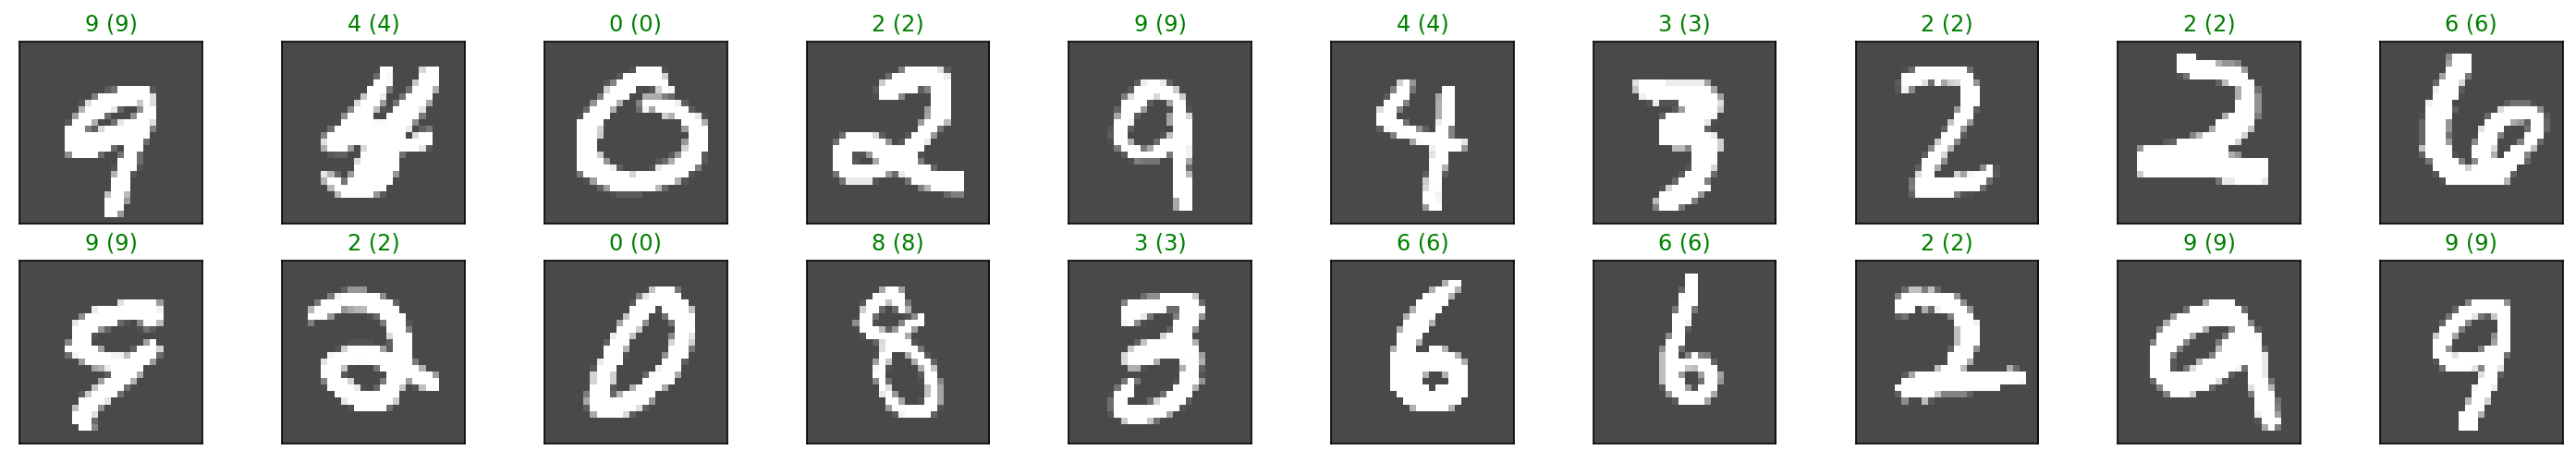

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))
